In [74]:
# -*- coding: utf-8 -*-
__author__ = 'nadya_motina'

import time
import codecs
import pandas
import operator
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import Word2Vec
from itertools import combinations
from transliterate import translit

In [5]:
start_time = time.time()
model = Word2Vec.load_word2vec_format('../../Models/ruscorpora.model.bin', binary=True)
print 'Model loaded successfully. It took ', time.time() - start_time, ' seconds'

Model loaded successfully. It took  8.37661004066  seconds


In [7]:
infile = codecs.open('freqrnc2011.csv', 'r', 'utf8')
data = pandas.read_csv(infile, sep='\t')
infile.close()
data.head()

,Lemma,PoS,Freq(ipm),Doc
0,быть,v,"12160,7",34184
1,год,s,"3727,5",29477
2,мочь,v,"2912,3",25413
3,человек,s,2723,20423
4,сказать,v,"2396,6",15426


In [72]:
def process_word(i, data):
    # extracts necessary data from the table and make a readable word for word2vec model
    # input: index, table
    # output: "word_S"
    pos = data['PoS'][i]
    ipm = float(data['Freq(ipm)'][i])
    lemma = (data['Lemma'][i] + '_' + pos.upper()).decode('utf8')
    return lemma

def build_rng(word, model, topn=10):
    # 1) find N most similar words from the model
    # 2) for each combination of 2 words find if there is some other neighbor in between them
    #    * if there is no such word: add an edge
    # output: graph object
    wg = nx.DiGraph()
    neighbors = model.most_similar(word, topn=topn)
    neighbors.append((word, 1.0))
    for pair in combinations(neighbors, 2):
        word0 = pair[0][0]
        word1 = pair[1][0]
        similarity = model.similarity(word0, word1)
        if similarity > 0:
            remaining = [vertex for vertex in neighbors if vertex != pair[0] \
                         and vertex != pair[1]]
            for vertex in remaining:
                drawedge = True
                candidate = vertex[0]
                if model.similarity(candidate, word1) > similarity \
                and model.similarity(candidate, word0) > similarity:
                    drawedge = False
                    break
                if drawedge == True:
                    w1 = translit(pair[0][0], 'ru', reversed=True) 
                    w2 = translit(pair[1][0], 'ru', reversed=True)
                    wg.add_edge(w1, w2, weight=similarity)
    #wg.remove_node(translit(word, 'ru', reversed=True))
    return wg.to_undirected(), translit(word, 'ru', reversed=True)
 
def draw_rng(wg):
    print nx.info(wg)
    elarge=[(u,v) for (u,v,d) in wg.edges(data=True) if d['weight'] > 0.45]
    esmall=[(u,v) for (u,v,d) in wg.edges(data=True) if d['weight'] <= 0.45]
    plt.figure(figsize=(10,10))
    plt.axis('off')
    pos = nx.spring_layout(wg)
    nx.draw_networkx_nodes(wg, pos, node_size=200, alpha=0.3, node_color='green')
    nx.draw_networkx_edges(wg, pos, edgelist=elarge, width=4, alpha=0.7, edge_color='g')
    nx.draw_networkx_edges(wg, pos, edgelist=esmall, width=4, alpha=0.2, edge_color='b', style='dashed')
    nx.draw_networkx_labels(wg, pos, font_size=16, font_family='sans-serif')

**Теперь**
1. к данному слову найдем ближайшие k соседей с помощью most_similar
2. затем из этого списка построим RNG

Name: 
Type: Graph
Number of nodes: 26
Number of edges: 178
Average degree:  13.6923


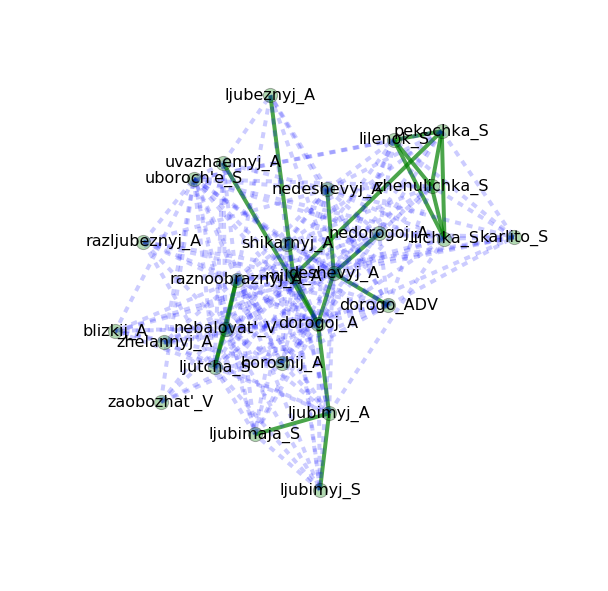

In [76]:
graph, node = build_rng('дорогой_A'.decode('utf8'), model, topn=25)
draw_rng(graph)
# nx.write_graphml(graph, "test.graphml", encoding='utf-8')

In [75]:
clusterings = nx.clustering(graph)
sorted_clusterings = sorted(clusterings.items(), key=operator.itemgetter(1))
sorted_clusterings

[(u'milyj_A', 0.4857142857142857),
 (u'dorogoj_A', 0.5274725274725275),
 (u'deshevyj_A', 0.5641025641025641),
 (u"uboroch'e_S", 0.5909090909090909),
 (u"nebalovat'_V", 0.6363636363636364),
 (u'ljubeznyj_A', 0.6666666666666666),
 (u'dorogo_ADV', 0.6944444444444444),
 (u'uvazhaemyj_A', 0.7),
 (u'ljubimyj_A', 0.8571428571428571),
 (u'horoshij_A', 0.8571428571428571),
 (u'zhelannyj_A', 0.8571428571428571),
 (u'blizkij_A', 0.9523809523809523),
 (u'razljubeznyj_A', 1.0),
 (u'ljubimyj_S', 1.0),
 (u"zaobozhat'_V", 1.0),
 (u'lilenok_S', 1.0)]